### RAG Pipeline Creation


- In this step, we will create a database to store the research papers for a given user query. To do this, we first need to retrieve a list of relevant papers from the arXiv API for the query.

- We will be using the ArxivLoader() package from LangChain as it abstracts API interactions, and retrieves the papers for further processing. 

- We can split these papers into smaller chunks to ensure efficient processing and relevant information retrieval later on. To do this, we will use the RecursiveTextSplitter() from LangChain, since it ensures semantic preservation of information while splitting documents. 

- Next, we will create embeddings for these chunks using the sentence-transformers embeddings from HuggingFace. Finally, we will ingest these split document embeddings into a Chroma DB database for further querying.

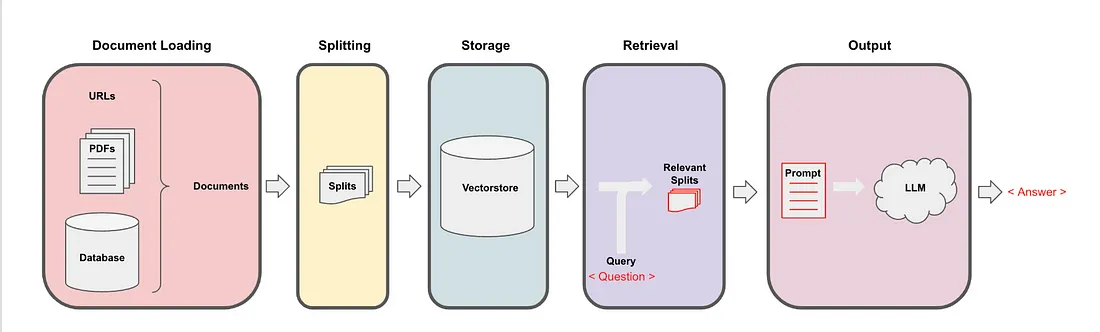

In [1]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import ArxivLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain_community.llms import Replicate

### Document Loading

In retrieval augmented generation (RAG) framework, an LLM retrieves contextual documents from an external dataset as part of its execution. This is useful when we want to ask questions about specific documents (e.g., PDFs, videos, etc). If we want to create an application to chat with our data, we need to first load our data into a format where it can be worked with.

In [2]:
query = "lightweight transformers for language tasks"
arxiv_docs = ArxivLoader(query=query, load_max_docs=3).load()

### Document Splitting

Document Splitting is required to split documents into smaller chunks. Document splitting happens after we load data into standardised document format but before it goes into the vector store.

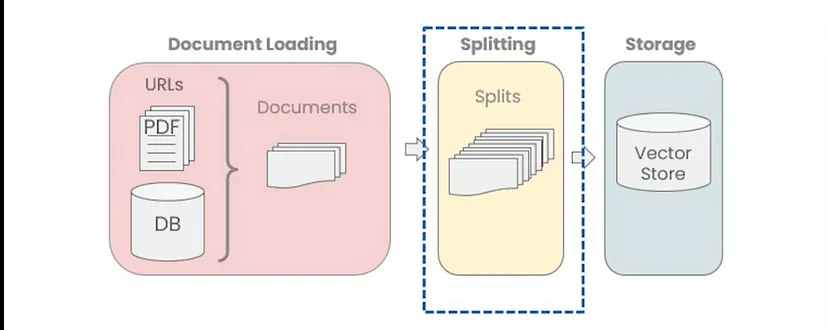

Splitting documents into smaller chunks is important and tricky as we need to maintain meaningful relationships between the chunks. For example, if have 2 chunks on Toyota Camry as follows:

    chunk 1: on this model. The Toyota Camry has a head-snapping

    chunk 2: 80 HP and an eight-speed automatic transmission that will

In this case, we did a simple splitting and we ended up with part of the sentence in one chunk, and the other part of the sentence in another chunk. So we will not be able to answer a question about the specifications of the Camry due to lack of right information in either chunk. So it is important that we split the chunks into semantically relevant chunks.


#### Types of Spiltters in LangChain

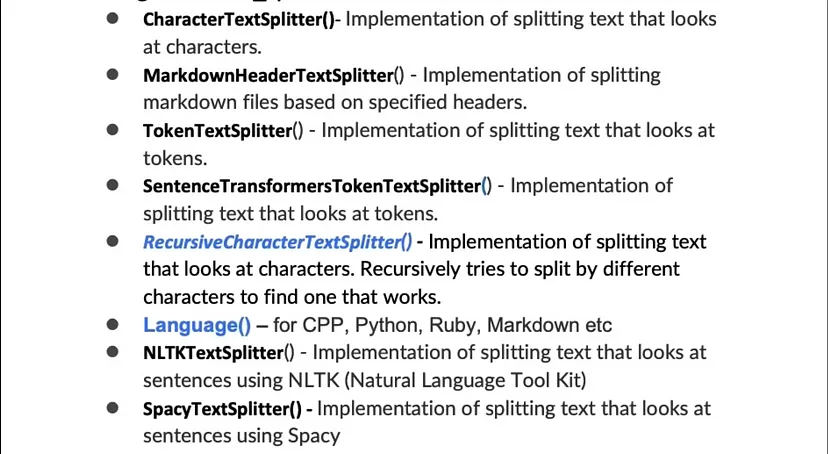


In [3]:
pdf_data = []

for doc in arxiv_docs:
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=100,
    )
    texts = text_splitter.create_documents([doc.page_content])
    pdf_data.append(texts)


### Vector Stores and Embeddings

We split up our document into small chunks and now we need to put these chunks into an index so that we are able to retrieve them easily when we want to answer questions on this document. We use embeddings and vector stores for this purpose.

Vector stores and embeddings come after text splitting as we need to store our documents in an easily accessible format. Embeddings take a piece of text and create a numerical representation of the text. Thus, text with semantically similar content will have similar vectors in embedding space. Thus, we can compare embeddings(vectors) and find texts that are similar.

The whole pipeline starts with documents. We split these documents into smaller splits and create embeddings of those splits or documents. Finally, we store all these embeddings in a vector store.

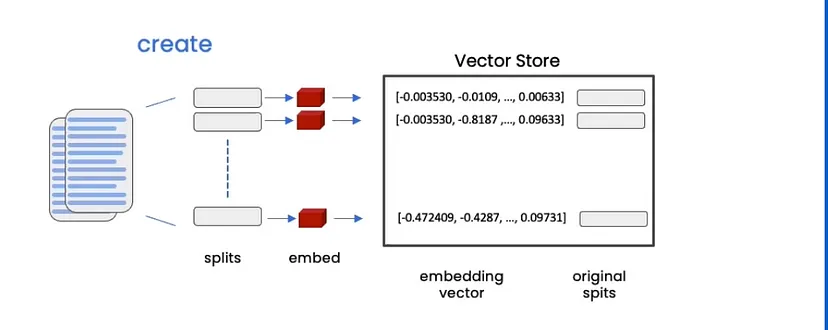

In [4]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-l6-v2")
db = Chroma.from_documents(pdf_data[0], embedding=embeddings)

c:\Users\shiva\OneDrive\Desktop\Data Science\Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Retrieval and Generation

- Once the database for a particular topic has been created, we can use this database as a retriever to answer user questions based on the provided context. LangChain offers a few different chains for retrieval, the simplest being the RetrievalQA chain that we will use. We will set it up using the from_chain_type() method, specifying the model and the retriever. For document integration into the LLM, we’ll use the stuff chain type, as it stuffs all documents into a single prompt.



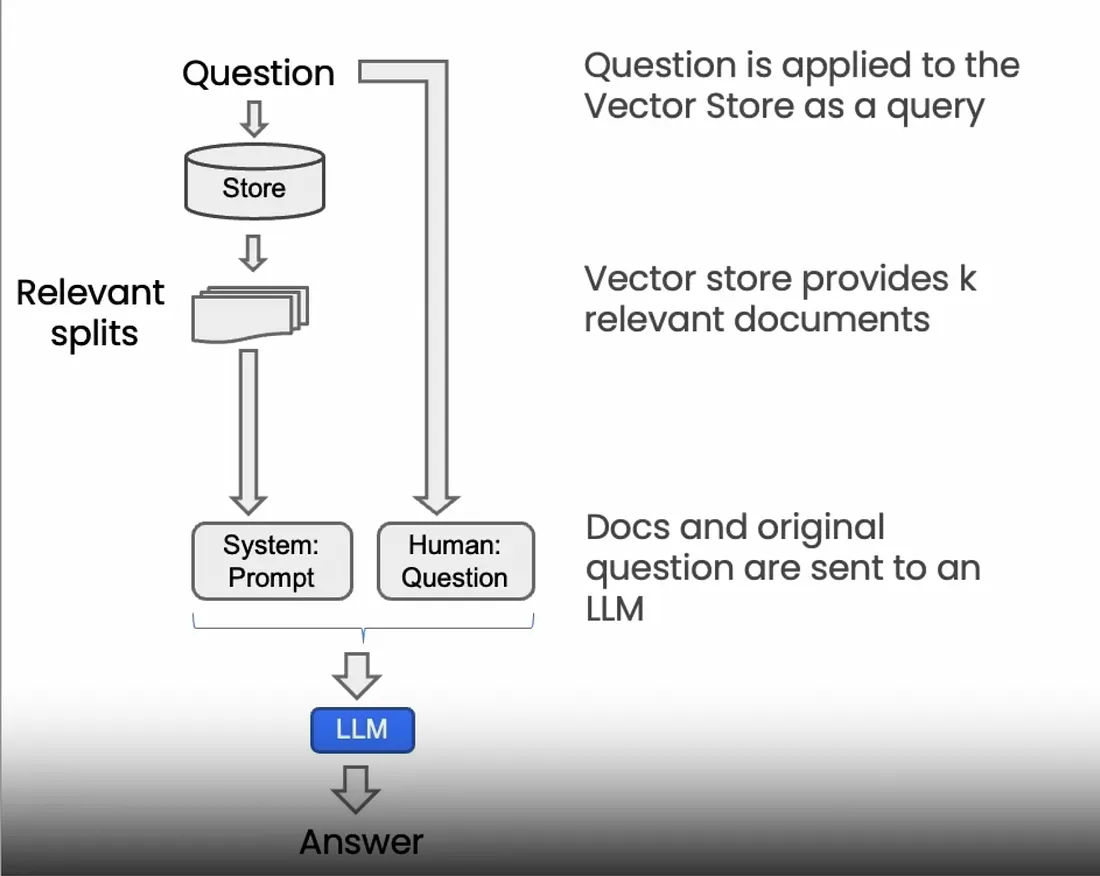

We used the “stuff” method by default, which stuffs all the relevant documents from vector store into the final prompt. This involves only one call to the language model. But, in case we have too many documents, the documents may not fit inside the context window. In such cases, we may use different techniques namely map-reduce, refine and map_rerank.

In this technique, each of the individual documents is first sent to the language model to get an original answer and then these answers are composed into a final answer with a final call to the language model. This involves many more calls to the language model, but it does have the advantage that it can operate over arbitrarily many documents.

In [5]:
llm = Replicate(
    model="meta/meta-llama-3-70b-instruct",
    model_kwargs={"temperature": 0.0, "top_p": 1, "max_new_tokens": 1000},
)



qa = RetrievalQA.from_chain_type(
    llm=llm, chain_type="stuff", retriever=db.as_retriever()
)

In [7]:
question = "Overview of language models, their applications, and their capabilities?"
answer = qa({"query": question})
answer

{'query': 'Overview of language models, their applications, and their capabilities?',
 'result': 'Based on the provided context, here is an overview of language models, their applications, and their capabilities:\n\n**Overview of Language Models:**\nLanguage models, such as ChatGPT and GPT-4, are pre-trained using self-supervised learning, which leverages the data itself as supervision. They can capture different levels of language representation, such as words, sentences, or documents. The process of training a language model involves data preparation, pre-training, and fine-tuning.\n\n**Applications:**\nLanguage models have various applications, including:\n\n* Natural Language Processing (NLP) tasks, such as text summarization, question answering, and language translation\n* Multi-player games, such as Poker\n* Visual reasoning and coordination\n* Medium-range global weather forecasting\n* Multi-modal modeling with in-context instruction tuning\n\n**Capabilities:**\nLanguage models 